# Analyze progeny viral barcodes
This Python Jupyter notebook processes viral barcodes from inside cells (Hoffman-primed vRNA) or supernatants (Hoffman-primed vRNA).

In [1]:
# Parameters
samples_csv = 'data/illumina_runs_viralbc.csv'
expected_flu_seqs = {
    'fluHA': 'GCGGCCGCCTATGGTGCATCATTATATGCAAAT',
    'fluNA': 'GCGGCCGCCTATGGTGCACTATTATTTATCTAT'
}

## Import Python modules
We use [plotnine](https://plotnine.readthedocs.io/) for ggplot2-style plotting:

In [2]:
import os
import subprocess

import numpy
import gzip

from Bio import SeqIO

import pandas as pd

from plotnine import *

from IPython.display import display, HTML
import mizani

Color-blind palette:

In [3]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [4]:
_ = theme_set(theme_classic)

## Read the viral barcode files

In [5]:
print(f"Reading sample list from from {samples_csv}")
samples_df = pd.read_csv(samples_csv, index_col=False, comment="#")

Reading sample list from from data/illumina_runs_viralbc.csv


In [6]:
samples_df

,sample,seqrun,source_type,segment,index_name,index_sequence,FASTQ
0,WT_0d15,2020-08-24,cell,fluHA,NextFlex_65,TGGAACAA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
1,WT_0d5,2020-08-25,cell,fluHA,NextFlex_66,TGGCTTCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
2,dblSyn_0d15,2020-08-26,cell,fluHA,NextFlex_67,TGGTGGTA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
3,dblSyn_0d5,2020-08-27,cell,fluHA,NextFlex_68,TTCACGCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
4,WT_0d15,2020-08-28,supernatant,fluHA,NextFlex_70,AAGAGATC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
5,WT_0d5,2020-08-29,supernatant,fluHA,NextFlex_71,AAGGACAC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
6,dblSyn_0d15,2020-08-30,supernatant,fluHA,NextFlex_72,AATCCGTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
7,dblSyn_0d5,2020-08-31,supernatant,fluHA,NextFlex_73,AATGTTGC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
8,WT_0d15,2020-09-01,passage,fluHA,NextFlex_75,ACAGATTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
9,WT_0d5,2020-09-02,passage,fluHA,NextFlex_76,AGATGTAC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...


### Trim adapters
Trim adapters using a command line call to cutadapt.

In [7]:
adapter_seq = 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCACN{8}ATCTCGTATGCCGTCTTCTGCTTG'

trimmed_fastq_files = []

for sample in samples_df.iterrows():
    raw_file = sample[1]["FASTQ"]
    output_file = 'results/temp_viralbc_fastqs/' + 'trimmed_' + sample[1]["FASTQ"].split('/')[-1]
    print(f'Trimming adapters for sample {sample[1]["sample"]} {sample[1]["source_type"]}.')
    cmd = [
        'cutadapt',
        '-O', '13',
        '-a', adapter_seq+'X',
        '-o', output_file,
        raw_file
          ]
    #print(' '.join(cmd))
    if os.path.exists(output_file):
        print('Trimmed file exists.')
    else:
        subprocess.check_call(cmd)
        print('Done.')
    trimmed_fastq_files.append(output_file)

samples_df['trimmed_FASTQ'] = trimmed_fastq_files

Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d15 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d5 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.


In [8]:
#abc = samples_df.query('"WT_0d15" in sample and segment == "fluHA"')

reads_list = []

for sample in samples_df.iterrows():
    fastq_file = sample[1]["trimmed_FASTQ"]
    print(f'Loading reads for sample {sample[1]["sample"]} {sample[1]["segment"]} from {fastq_file}\n')
    with gzip.open(fastq_file, "rt") as fastq_file_open:
        reads = SeqIO.parse(fastq_file_open, format='fastq')
        for record in reads:
            reads_list.append({
                'sample': sample[1]["sample"],
                'source_type': sample[1]["source_type"],
                'segment': sample[1]["segment"],
                'read_name': record.name,
                'sequence': str(record.seq),
                #'phred': record.letter_annotations["phred_quality"],
            })

reads_df = pd.DataFrame(reads_list)
reads_df['source_type'] = pd.Categorical(reads_df['source_type'],
                                        categories=['cell','supernatant','passage'],
                                        ordered=True)
#reads_df

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-015_S1_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-05_S2_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-015_S3_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-05_S4_L001_R1_001.fastq.gz

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-015_S5_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-05_S6_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-dblSyn-015_S7_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-dblSyn-05_S8_L001_R

## Parse the viral barcode and segment identity

In [9]:
reads_df['viral_bc'] = reads_df['sequence'].str.slice(0,16)
#reads_df['viral_bc_qual'] = numpy.mean(reads_df['phred'].str.slice(0,16))
reads_df['flu_seq'] = reads_df['sequence'].str.slice(16,49)
reads_df['expected_flu_seq'] = reads_df['segment'].map(expected_flu_seqs)
reads_df['match'] = reads_df['flu_seq'] == reads_df['expected_flu_seq']

def filter_reads(match):
    if match == False:
        return True
    else:
        return False

reads_df['filtered'] = reads_df.apply(lambda x: filter_reads(x['match']), axis=1)

In [10]:
reads_df

,sample,source_type,segment,read_name,sequence,viral_bc,flu_seq,expected_flu_seq,match,filtered
0,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:21755:2143,CCACGTAACAAATGGTGCGGCCGCCTATGGTGCATCATTATATGCA...,CCACGTAACAAATGGT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True,False
1,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:22590:2161,TACATCGCAAGAATGTGCGGCCGCCTATGGTGCATCATTATATGCA...,TACATCGCAAGAATGT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True,False
2,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:16793:2163,CAACATAAACTGTACGGCGGCCGCCTATGGTGCATCATTATATGCA...,CAACATAAACTGTACG,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True,False
3,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:9442:2179,ACTCCAGGGTAATGACGCGGCCGCCTATGGTGCATCATTATATGCA...,ACTCCAGGGTAATGAC,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True,False
4,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:19569:2181,CTCTTAGATACGCGGAGCGGCCGCCTATGGTGCATCATTATATGCA...,CTCTTAGATACGCGGA,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True,False
...,...,...,...,...,...,...,...,...,...,...
22662466,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:13088:25289,CAATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CAATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False,True
22662467,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:20396:25290,ACAACCTCGATTGCTAGCGGCCGCCTATGGTGCACNANNNNTTATC...,ACAACCTCGATTGCTA,GCGGCCGCCTATGGTGCACNANNNNTTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False,True
22662468,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:18079:25292,CAATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CAATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False,True
22662469,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:14885:25292,CTATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CTATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False,True


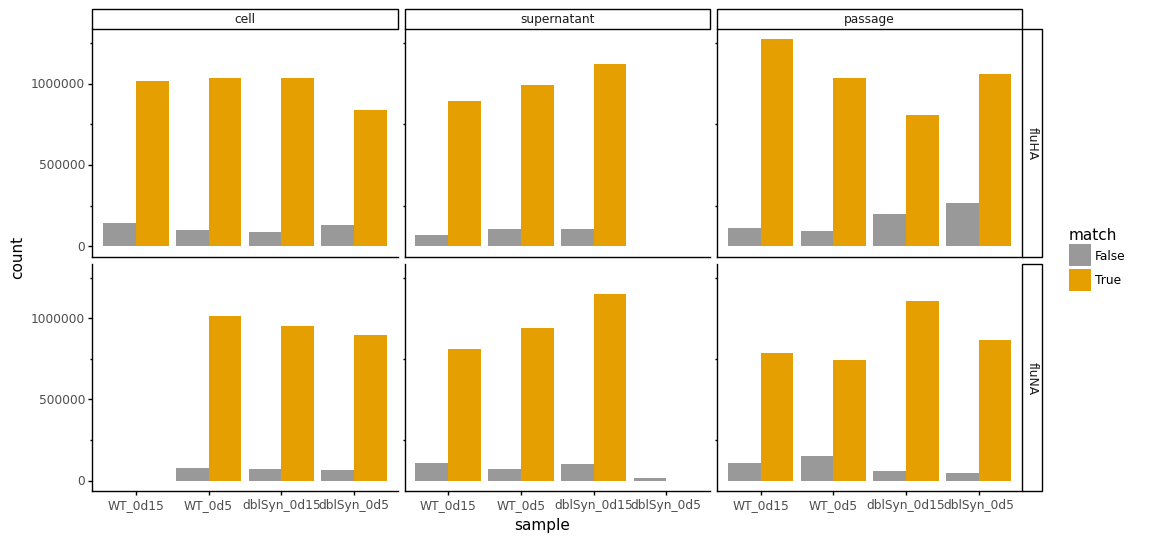

In [11]:
p = (ggplot(reads_df, aes(x='sample', fill='match')) +
     geom_bar(position='dodge') +
     facet_grid('segment~source_type') +
     theme(figure_size=(12, 6)) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [12]:
n_barcodes_df = pd.DataFrame(reads_df.query('not filtered').groupby(['sample','source_type','segment'])['viral_bc'].nunique())
n_barcodes_df = n_barcodes_df.reset_index()
n_barcodes_df = n_barcodes_df.rename(columns={'viral_bc':'n_viral_bc'})

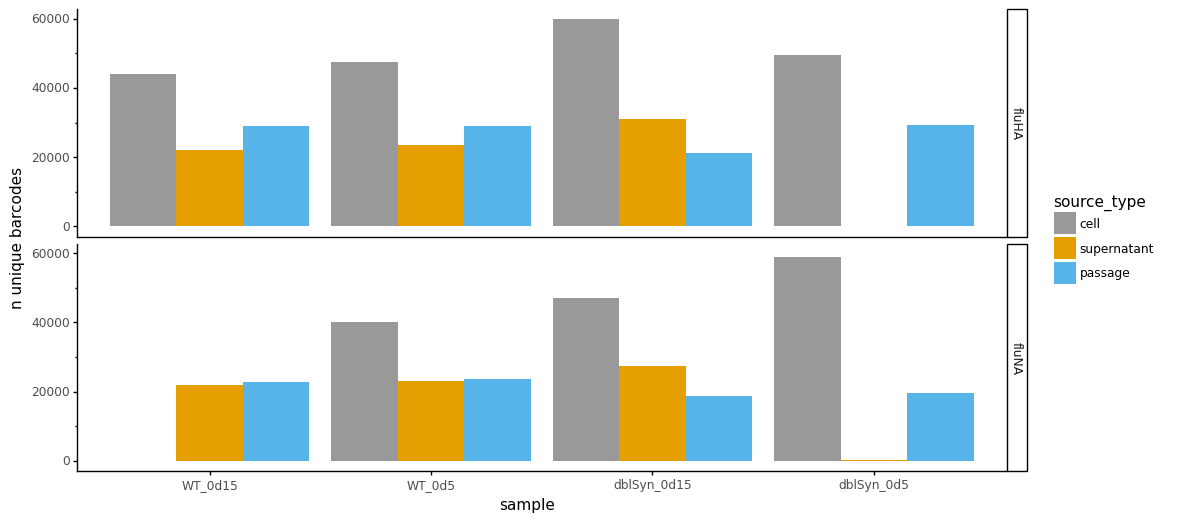

In [13]:
p = (ggplot(n_barcodes_df, aes(x='sample', y='n_viral_bc', fill='source_type')) +
     geom_bar(stat='identity',position='dodge') +
     facet_grid('segment~') +
     theme(figure_size=(12, 6)) +
     ylab('n unique barcodes') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [14]:
barcode_counts_df = pd.DataFrame(reads_df.query('not filtered').groupby(['sample','source_type','segment'])['viral_bc'].value_counts())
barcode_counts_df = barcode_counts_df.rename(columns={'viral_bc':'n_reads'})
barcode_counts_df = barcode_counts_df.reset_index(level=['viral_bc','sample','source_type','segment'])

# remove incomplete samples
barcode_counts_df = barcode_counts_df.query('sample != "WT_0d15" and sample != "dblSyn_0d5"')

threshold = 10 #cutoff for including a barcode
barcode_counts_df = barcode_counts_df.query(f'n_reads > {threshold}')

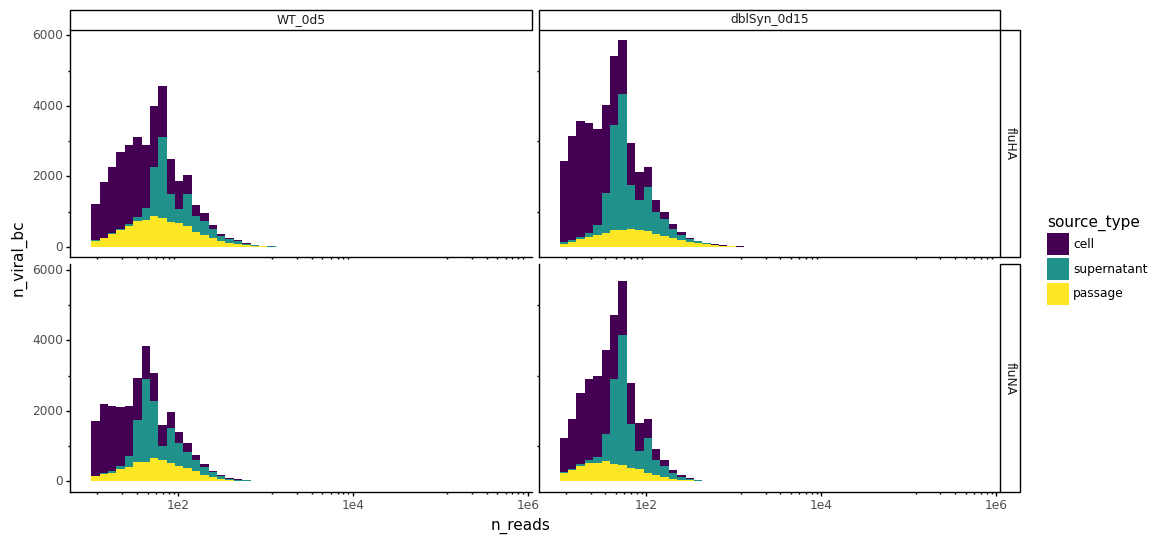

In [15]:
p = (ggplot(barcode_counts_df, aes(x='n_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ylab('n_viral_bc')
     )
_ = p.draw()

In [25]:
barcode_counts_wide = pd.pivot_table(barcode_counts_df, index=['sample','segment','viral_bc'], columns=['source_type'], values=['n_reads'])
#barcode_counts_wide = barcode_counts_wide.fillna(0)
barcode_counts_wide = barcode_counts_wide.rename(columns=str).reset_index()
barcode_counts_wide.columns = ['_'.join(tup) for tup in barcode_counts_wide.columns.values]
barcode_counts_wide = barcode_counts_wide.rename(columns={'viral_bc_': 'viral_bc', 'sample_': 'sample', 'segment_': 'segment'})

In [26]:
barcode_counts_wide

,sample,segment,viral_bc,n_reads_cell,n_reads_supernatant,n_reads_passage
0,WT_0d5,fluHA,AAAAAAAATCATACGA,NaN,66.0,NaN
1,WT_0d5,fluHA,AAAAAAAATTCAAAGT,19.0,NaN,NaN
2,WT_0d5,fluHA,AAAAAAACCCTCGGTA,17.0,NaN,NaN
3,WT_0d5,fluHA,AAAAAAAGTGGAACGC,12.0,NaN,NaN
4,WT_0d5,fluHA,AAAAAAATACTTGACA,37.0,NaN,NaN
...,...,...,...,...,...,...
119824,dblSyn_0d15,fluNA,TTTTTTTACTTGAATT,NaN,NaN,23.0
119825,dblSyn_0d15,fluNA,TTTTTTTATAATAAGT,NaN,NaN,16.0
119826,dblSyn_0d15,fluNA,TTTTTTTATTGGTAAT,NaN,151.0,NaN
119827,dblSyn_0d15,fluNA,TTTTTTTGTGTCGTTA,73.0,NaN,NaN


In [27]:
residence_df = barcode_counts_wide
residence_df['in_cell'] = residence_df['n_reads_cell'] > threshold
residence_df['in_supernatant'] = residence_df['n_reads_supernatant'] > threshold
residence_df['in_passage'] = residence_df['n_reads_passage'] > threshold

def parse_residence(source1, source2, source1_value, source2_value):
    if source1_value == True and source2_value == False:
        return source1
    elif source1_value == False and source2_value == True:
        return source2
    elif source1_value == True and source2_value == True:
        return 'both'
    elif source1_value == False and source2_value == False:
        return 'neither'

residence_df['cell_and_supernatant'] = residence_df.apply(lambda x: parse_residence(
                                                                    'cell', 'supernatant',
                                                                    x['in_cell'], x['in_supernatant']), axis=1)
residence_df['cell_and_supernatant'] = pd.Categorical(residence_df['cell_and_supernatant'],
                                                      categories=['neither','supernatant','both','cell'],
                                                      ordered=True)

residence_df['supernatant_and_passage'] = residence_df.apply(lambda x: parse_residence(
                                                                    'supernatant', 'passage',
                                                                    x['in_supernatant'], x['in_passage']), axis=1)
residence_df['supernatant_and_passage'] = pd.Categorical(residence_df['supernatant_and_passage'],
                                                      categories=['neither','passage','both','supernatant'],
                                                      ordered=True)

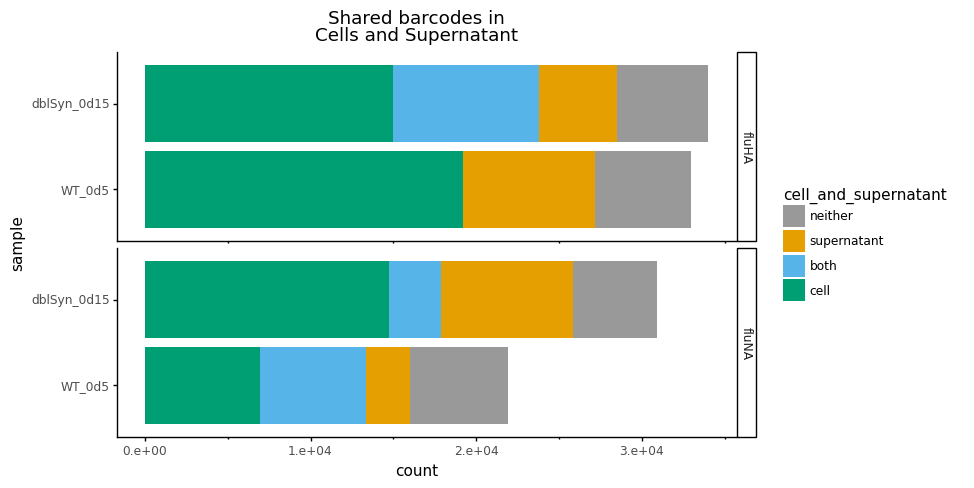

In [28]:
p = (ggplot(residence_df, aes(x='sample', fill='cell_and_supernatant')) +
     geom_bar(stat="count") +
     coord_flip() +
     facet_grid('segment~') +
     theme(figure_size=(8, 5)) +
     ggtitle('Shared barcodes in\nCells and Supernatant') +
     scale_y_continuous(labels=mizani.formatters.scientific_format()) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

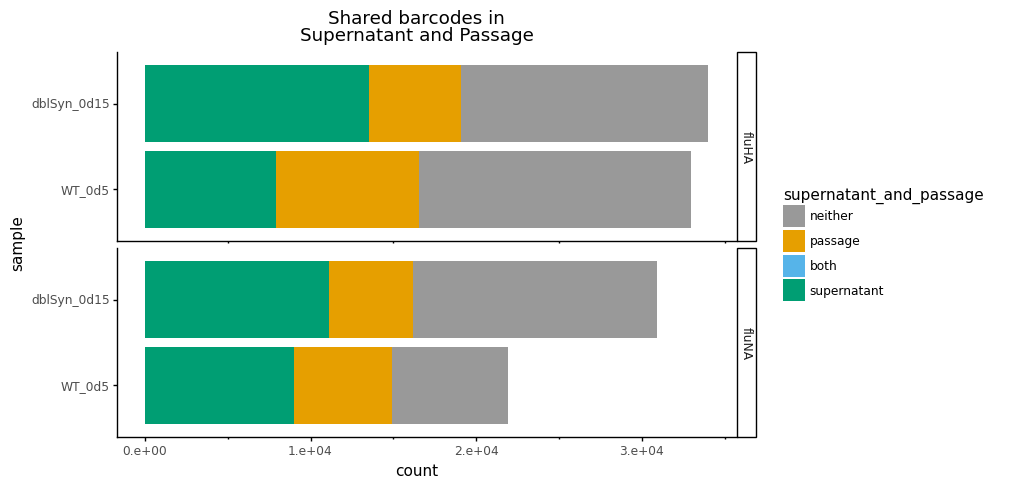

In [29]:
p = (ggplot(residence_df, aes(x='sample', fill='supernatant_and_passage')) +
     geom_bar(stat='count') +
     coord_flip() +
     facet_grid('segment~') +
     theme(figure_size=(8, 5)) +
     ggtitle('Shared barcodes in\nSupernatant and Passage') +
     scale_y_continuous(labels=mizani.formatters.scientific_format()) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [22]:
# barcode_counts_wide["n_reads_cell"].corr(barcode_counts_wide["n_reads_supernatant"])
# barcode_counts_wide["n_reads_supernatant"].corr(barcode_counts_wide["n_reads_passage"])

In [32]:
p = (ggplot(barcode_counts_wide.fillna({'n_reads_cell':0,'b':0}), aes(x='n_reads_cell', y='n_reads_supernatant')) +
     geom_point() +
     geom_smooth(method='lm') +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10(labels=mizani.formatters.scientific_format()) +
     scale_y_log10(labels=mizani.formatters.scientific_format())
     )
_ = p.draw()

ValueError: fill value must be in categories

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/utils.py:634: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 119802 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


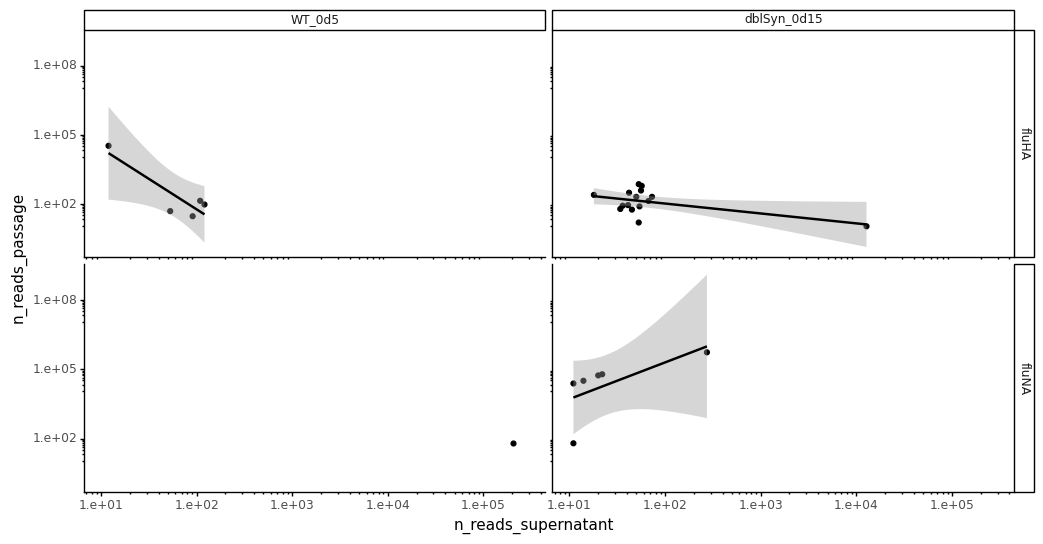

In [31]:
p = (ggplot(barcode_counts_wide, aes(x='n_reads_supernatant', y='n_reads_passage')) +
     geom_point() +
    geom_smooth(method='lm') +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10(labels=mizani.formatters.scientific_format()) +
     scale_y_log10(labels=mizani.formatters.scientific_format())
     )
_ = p.draw()